In [1]:
import cv2
fileName='1108_NTS-01132021132833.avi'  # change the file name if needed
cap = cv2.VideoCapture(fileName)  # load the video
ret, frame = cap.read() # Read the frame

### Check number of frames in the video

In [2]:
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(length)

76157


Because there are 33fps, thus 76157/33 = 2307.667 seconds = 38.46mins

### Check with Camera BNC1 output from rawdataframe

In [3]:
import pandas as pd 
import numpy as np
raw_sessiondata = pd.read_csv("20210113-133853.csv", skiprows=6, delimiter = ';')

#Add a column for 'timestamps'
import time
import datetime
import ciso8601

timestamp = []
for i in range(len(raw_sessiondata.index)):
    t = raw_sessiondata['PC-TIME'].iloc[i]
    ts= ciso8601.parse_datetime(t)
    if i == 0:
        t0= time.mktime(ts.timetuple())+ts.microsecond/1000000
        timestamp.append(np.around(t0-t0,3))
    else:
        tnow = time.mktime(ts.timetuple())+ts.microsecond/1000000
        timestamp.append(np.around(tnow-t0,3))

raw_sessiondata['timestamps'] = timestamp

In [4]:
df_group_msg = raw_sessiondata.groupby('MSG')

#### Find timestamp for Camera ON and Off

In [5]:
cameraoff = df_group_msg.get_group('BNC1_CameraOFF')
cam_end = cameraoff['timestamps'].to_numpy()

In [6]:
cameraon = df_group_msg.get_group('BNC1_CameraON')
cam_start = cameraon['timestamps'].to_numpy()

In [7]:
print('total time of camera being on in session:' + str(cam_end - cam_start))

total time of camera being on in session:[2307.397]


## Align Video Frame with Reward

There are unsupervised pipeline to use in order to cluster facial expression: https://www.geeksforgeeks.org/ml-unsupervised-face-clustering-pipeline/

### I. Decode the Licking Stimulus Frame to Non-licking Frame

1. select all the frames that correspond to licking 
2. randomly select same number of frame in others
3. Divide the set in half / 0.7 -> feed into the Decoding Model (Logistic Regression)
4. Give it the other half/0.3 -> predict which of the facial expression is important

https://zenodo.org/record/3618395#.YC1yws9KjBN

#### Lick ON timestamps (verification: look at session.reward.ipynb)

In [8]:
# Get lick onsets 
df_group_info = raw_sessiondata.groupby('+INFO')
df_port1out = df_group_info.get_group('Port1Out')
timestamps_lickon = df_port1out.timestamps.to_numpy()
timestamps_lickon

array([   7.912,    8.191,    8.541, ..., 2308.027, 2308.196, 2308.301])

### Get Video Frame specifically to 'lick ON' timestamps

Because there are 33fps, thus each 1s = 33 frames; 
i.e. to get the first lick ON timestamp: '7.912s' -> its corresponding video frame would be 7.912x33

In [9]:
videoframe_lick = timestamps_lickon*33
videoframe_lick

array([  261.096,   270.303,   281.853, ..., 76164.891, 76170.468,
       76173.933])

#### E.g. Getting specific. single video frame using cv2 (example: first lick timeframe)

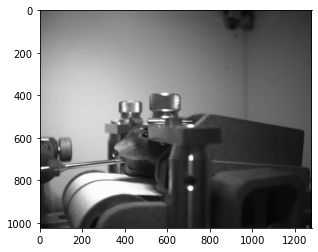

In [10]:
import matplotlib.pyplot as plt 
frame_no = videoframe_lick[0]
cap.set(1,frame_no);  #showing frame number 100
success = cap.grab()
ret, image = cap.retrieve()
plt.imshow(image)

### Get all the frames of licking

In [11]:
print('The total number of video frames that corresponds to licking: ' + str(len(videoframe_lick)))

The total number of video frames that corresponds to licking: 2136


Okay, because it was wayyyy to much, I decided to only try taking the first 100

In [27]:
count = 0
for i in videoframe_lick[:101]:
    frame_no = i
    cap.set(1,frame_no);  #taking desired frame 
    ret, image = cap.read()
    
    if ret:
        cv2.imwrite('frame{:d}.jpg'.format(count), image)
        count += 33

    else:
        cap.release()
        break
    

### Get all the frames of non-licking (first 100)

In [15]:
non_lickvideoframe = [videoframe_lick[i]+3 for i in range(100)] #assumption: +3s after licking = no licking (need check)

In [46]:
count = 0
for i in non_lickvideoframe:
    frame_no = i
    cap.set(1,frame_no);  #taking desired frame 
    ret, image = cap.read()
    
    if ret:
        cv2.imwrite('nonlick{:d}.jpg'.format(count), image)
        count += 33

    else:
        cap.release()
        break

### Convert saved images (that's in jpg) into np array form -> store in matrix

In [12]:
from PIL import Image
from numpy import asarray
lick_array = []
count = 0
for i in videoframe_lick[:100]:
    # load the image
    image = Image.open('frame'+str(count)+'.jpg')
    # convert image to numpy array
    data = asarray(image)
    lick_array.append(data)

In [13]:
np.shape(lick_array) #100 images, each in 1024x1280, in RBG form

(100, 1024, 1280, 3)

In [16]:
nonlick_array = []
count = 0
for i in non_lickvideoframe:
    # load the image
    image = Image.open('nonlick'+str(count)+'.jpg')
    # convert image to numpy array
    data = asarray(image)
    nonlick_array.append(data)

In [17]:
np.shape(nonlick_array) #100 images, each in 1024x1280, in RBG form

(100, 1024, 1280, 3)

## Logistic Regression Model

### Make Training and Testing Data

In [19]:
X = lick_array + nonlick_array
np.shape(X)

(200, 1024, 1280, 3)

Licking = 1; non-licking = 0

In [27]:
y = np.hstack((np.zeros(100),np.ones(100)))
np.shape(y)

(200,)

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

##### Convert RBG image to black and white

In [57]:
img_x_train = np.array(x_train)[:,:,:,0]
img_x_test = np.array(x_test)[:,:,:,0]
print(np.shape(img_x_train))
print(np.shape(img_x_test))

(100, 1024, 1280)
(100, 1024, 1280)


##### Flatten image (WOULD NOT DO IT IN CNN! - but its a scratch, so lets do this first)

In [58]:
img_ActualX_train = np.array(img_x_train).reshape(100,1024*1280)
img_ActualX_test = np.array(img_x_test).reshape(100,1024*1280)
np.shape(img_ActualX_train)

(100, 1310720)

### Feed into model

In [64]:
from sklearn.linear_model import LogisticRegression
lgmodel = LogisticRegression()
lgmodel.fit(img_ActualX_train, y_train)

LogisticRegression()

In [62]:
predictions = lgmodel.predict(img_ActualX_test)

### Accuracy Score of Model (VERY RAW)

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

1.0